## 개체명 인식(Named Entity Recognition)
+ 개체명 인식은 텍스트에서 이름을 가진 개체를 인식하는 기술      
+ 가령, '철수와 영희는 밥을 먹었다'에서 이름과 사물을 추출하는 개체명 인식 모델 결과 
    + 이름 : '철수', '영희'    
    + 사물 : '밥'
+ `nltk` 라이브러리에서는 미리 학습된 개체명 인식 모델을 제공

In [15]:
import nltk
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxnet_ne_chunker')

In [16]:
#토큰화, 품사태깅
from nltk import word_tokenize, pos_tag, ne_chunk

s = 'James is working at Disney in London.'
s = pos_tag(word_tokenize(s))  

s

[('James', 'NNP'),
 ('is', 'VBZ'),
 ('working', 'VBG'),
 ('at', 'IN'),
 ('Disney', 'NNP'),
 ('in', 'IN'),
 ('London', 'NNP'),
 ('.', '.')]

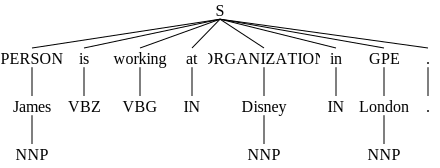

In [17]:
#개체명 인식
sentence = ne_chunk(s)

sentence

### LSTM을 이용한 개체명 인식
+ 사용자가 제공되고 있는 개체명 인식 모델과는 다른 개체명을 정의해 사용하는 것이 필요할 수 있음
+ 직접 개체명 인식 모델을 구성해 학습하고 사용할 수 있음

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import numpy as np
import urllib.request

In [19]:
#데이터 준비
tagged_sentences = []

with urllib.request.urlopen('https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt') as f:
    for line in f:
        line = line.decode('utf-8')
        if (len(line)==0) or (line.startswith('-DOCSTART')) or (line[0]=='\n'):
            if len(sentence) > 0:
                tagged_sentences.append(s)
                sentence = []
            continue
        splits = line.strip().split(' ')
        word = splits[0].lower()
        sentence.append([word, splits[-1]])

print(len(tagged_sentences))
tagged_sentences[0]

14042


[('James', 'NNP'),
 ('is', 'VBZ'),
 ('working', 'VBG'),
 ('at', 'IN'),
 ('Disney', 'NNP'),
 ('in', 'IN'),
 ('London', 'NNP'),
 ('.', '.')]

In [20]:
tagged_sentences[0]

[('James', 'NNP'),
 ('is', 'VBZ'),
 ('working', 'VBG'),
 ('at', 'IN'),
 ('Disney', 'NNP'),
 ('in', 'IN'),
 ('London', 'NNP'),
 ('.', '.')]

In [21]:
#전처리
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

In [22]:
#정제 및 빈도수가 높은 상위단어들만 추출하기 위해 토큰화 작업
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [23]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1

vocab_size, tag_size

(4000, 6)

In [24]:
#모델 투입 위해 배열로 변환
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [25]:
#padding
max_len = 70

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [26]:
#훈련/검증데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

#원핫인코딩
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11233, 70), (11233, 70, 6), (2809, 70), (2809, 70, 6))

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

model = Sequential([Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True),
Bidirectional(LSTM(256, return_sequences=True)),   #양방향 LSTM 구성
TimeDistributed(Dense(tag_size, activation='softmax'))])   #상위 layer의 출력이 step에 따라 여러개로 출력되어 적절히 분배되도록 함

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 128)           512000    
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 512)           788480    
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 6)             3078      
Total params: 1,303,558
Trainable params: 1,303,558
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test))

Train on 11233 samples, validate on 2809 samples
Epoch 1/5
11233/11233 [==============================] - 191s 17ms/sample - loss: 0.0598 - acc: 0.7935 - val_loss: 2.2180e-04 - val_acc: 1.0000
Epoch 2/5
11233/11233 [==============================] - 188s 17ms/sample - loss: 1.0610e-04 - acc: 1.0000 - val_loss: 5.9049e-05 - val_acc: 1.0000
Epoch 3/5
11233/11233 [==============================] - 189s 17ms/sample - loss: 4.2947e-05 - acc: 1.0000 - val_loss: 3.1207e-05 - val_acc: 1.0000
Epoch 4/5
11233/11233 [==============================] - 185s 17ms/sample - loss: 2.4879e-05 - acc: 1.0000 - val_loss: 1.9796e-05 - val_acc: 1.0000
Epoch 5/5
11233/11233 [==============================] - 184s 16ms/sample - loss: 1.6596e-05 - acc: 1.0000 - val_loss: 1.3875e-05 - val_acc: 1.0000


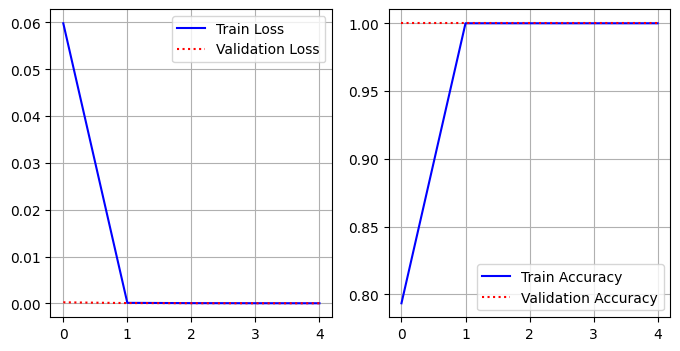

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_acc'], 'r:', label='Validation Accuracy')
plt.legend()
plt.grid();

#### 학습한 모델을 통한 예측
+ 예측을 확인하기 위해 인덱스를 단어로 변환해줄 사전 필요

In [30]:
idx2word = src_tokenizer.index_word
idx2ner = tar_tokenizer.index_word
idx2ner[0] = 'PAD'

In [32]:
#예측 시각화
y_pred = model.predict(np.array([X_test[10]]))
y_pred = np.argmax(y_pred, axis=-1)
true = np.argmax(y_test[10], -1)

print('{:15}|{:5}|{}'.format('단어', '실제값', '예측값'))
print('-'*40)

for w, t, pred in zip(X_test[10], true, y_pred[0]):
    if w != 0:
        print('{:17}|{:7}|{}'.format(idx2word[w], idx2ner[t].upper(), idx2ner[pred].upper()))

단어             |실제값  |예측값
----------------------------------------
james            |NNP    |NNP
is               |VBZ    |VBZ
working          |VBG    |VBG
at               |IN     |IN
disney           |NNP    |NNP
in               |IN     |IN
london           |NNP    |NNP
.                |.      |.
